<a href="https://colab.research.google.com/github/sdsc-bw/DataFactory/blob/develop/preprocessing/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src = '../images/data_cleaning.png'>
The quality of the data directly determines quality of the prediction and generalization ability of the model. It involves many factors, including: accuracy, completeness, consistency, credibility. In the real world, the data we get may contain a lot of missing values, noise, or due to manual entry errors there may be outliers present, which is very unfavorable to the training of algorithmic models. The result of data preproessing is to process all kinds of dirty data in a corresponding way to get standard, clean and continuous data, which can be used for data statistics, data mining, etc.

# Import Packages

In [1]:
import sys

In [2]:
if 'google.colab' in sys.modules:
    ! git clone https://github.com/sdsc-bw/DataFactory.git
    ! ls

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from abc import ABCMeta, abstractmethod
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import cast, Any, Dict, List, Tuple, Optional, Union
import logging

if 'google.colab' in sys.modules:
    root = 'Datafactory/'
else:
    root = '../'
sys.path.insert(0, root + "codes")

from DataFactory import DataFactory
from transforms import UnaryOpt, BinaryOpt, MultiOpt
import transforms as tfd

# Data description
<a href = 'https://archive.ics.uci.edu/ml/citation_policy.html'>credit-german</a> classifies people described by a set of attributes as good or bad credit risks.
- 'checking_status': Status of existing checking account, in Deutsche Mark.  
- 'duration': Duration in months  
- 'credit_history': Credit history (credits taken, paid back duly, delays, critical accounts)  
- 'purpose': Purpose of the credit (car, television,...)  
- 'credit_amount': Credit amount  
- 'savings_status': Status of savings account/bonds, in Deutsche Mark.  
- 'employment': Present employment, in number of years.  
- 'installment_commitment': Installment rate in percentage of disposable income  
- 'personal_status': Personal status (married, single,...) and sex  
- 'other_parties': Other debtors / guarantors  
- 'residence_since': Present residence since X years  
- 'property_magnitude': Property (e.g. real estate)  
- 'age': Age in years  
- 'other_payment_plans': Other installment plans (banks, stores)  
- 'housing': Housing (rent, own,...)  
- 'existing_credits': Number of existing credits at this bank  
- 'job': Job  
- 'num_dependents': Number of people being liable to provide maintenance for  
- 'own_telephone': Telephone (yes,no)  
- 'foreign_worker': Foreign worker (yes,no)

# Data import 

When extracting csv files, there are three points to pay special attention to Delimiter, header, index_col. When they are set up incorrectly, it is easy to cause confusion in the data structure.
Using the following data reading as examples:
- we know that the delimiter for dataset_31_credit-g is ';'. When we use the default separator ',', all the data will be stacked into one property. 
- Similarly, if we extract the data with a note that there is no header, then the first row in the data will be treated as an attribute value.

In [4]:
df = pd.read_csv(root + 'data/dataset_31_credit-g.csv', sep = ',')
df.head()

,;checking_status;duration;credit_history;purpose;credit_amount;savings_status;employment;installment_commitment;personal_status;other_parties;residence_since;property_magnitude;age;other_payment_plans;housing;existing_credits;job;num_dependents;own_telephone;foreign_worker;class
0,0;'<0';6;'critical/other existing credit';radi...
1,1;'0<=X<200';48;'existing paid';radio/tv;5951;...
2,2;'no checking';12;'critical/other existing cr...
3,3;'<0';42;'existing paid';furniture/equipment;...
4,4;'<0';24;'delayed previously';'new car';4870;...


In [5]:
df = pd.read_csv(root + 'data/dataset_31_credit-g.csv', sep = ';', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,NaN,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
1,0.0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',...,'real estate',67.0,none,own,2,skilled,1,yes,yes,good
2,1.0,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',...,'real estate',22.0,none,own,1,skilled,1,none,yes,bad
3,2.0,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',...,'real estate',49.0,none,own,1,'unskilled resident',2,none,yes,good
4,3.0,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',...,'life insurance',45.0,none,'for free',1,skilled,2,none,yes,good


Only after these parameters have been set correctly will the data be extracted

In [6]:
df = pd.read_csv(root + 'data/dataset_31_credit-g.csv', sep = ';', header = 'infer', index_col = 0)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67.0,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22.0,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49.0,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45.0,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53.0,none,'for free',2,skilled,2,none,yes,bad


In [7]:
dfx = df.iloc[:, :-1]
dfy = df.iloc[:, -1]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   int64  
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   int64  
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   int64  
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   int64  
 11  property_magnitude      1000 non-null   object 
 12  age                     999 non-null    float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

# Data Cleaning

The main idea of data cleaning is to "clean" data by filling in missing values, smoothing noisy data, smoothing or removing outliers, and resolving data inconsistencies. If customers think the data is dirty, they are less likely to trust the results based on this data i.e., the output is unreliable§.

## Categorical features
Many popular models can't handle character feature, e.g., neural network

To handle these attributes, we generally convert the character data into numeric data via:
-  <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html'>LabelEncoder</a> or 
- <a href= 'https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html'>OnehotEncoder</a>

From the above example we can see that there are a large number of character features in the data. We show a few examples below:

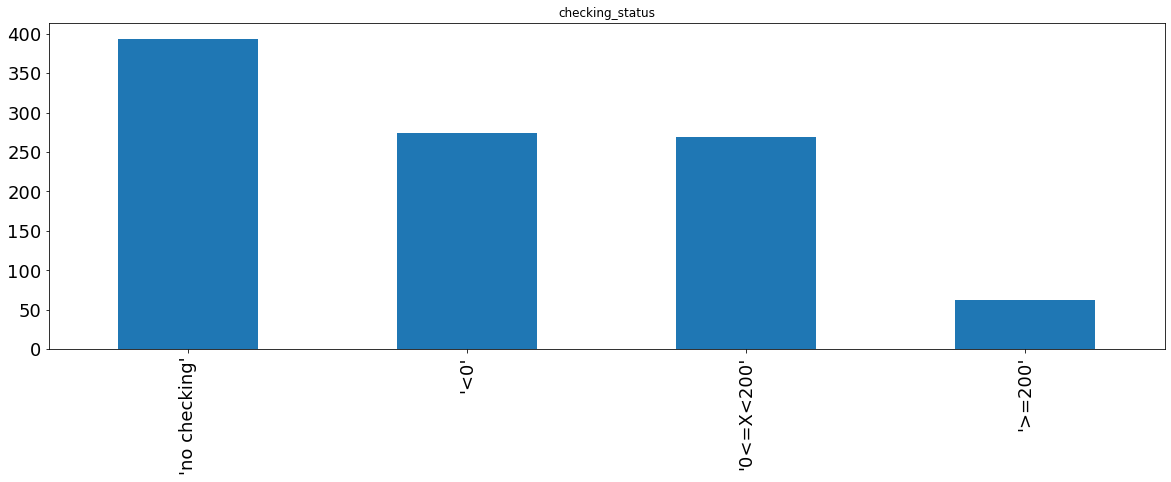

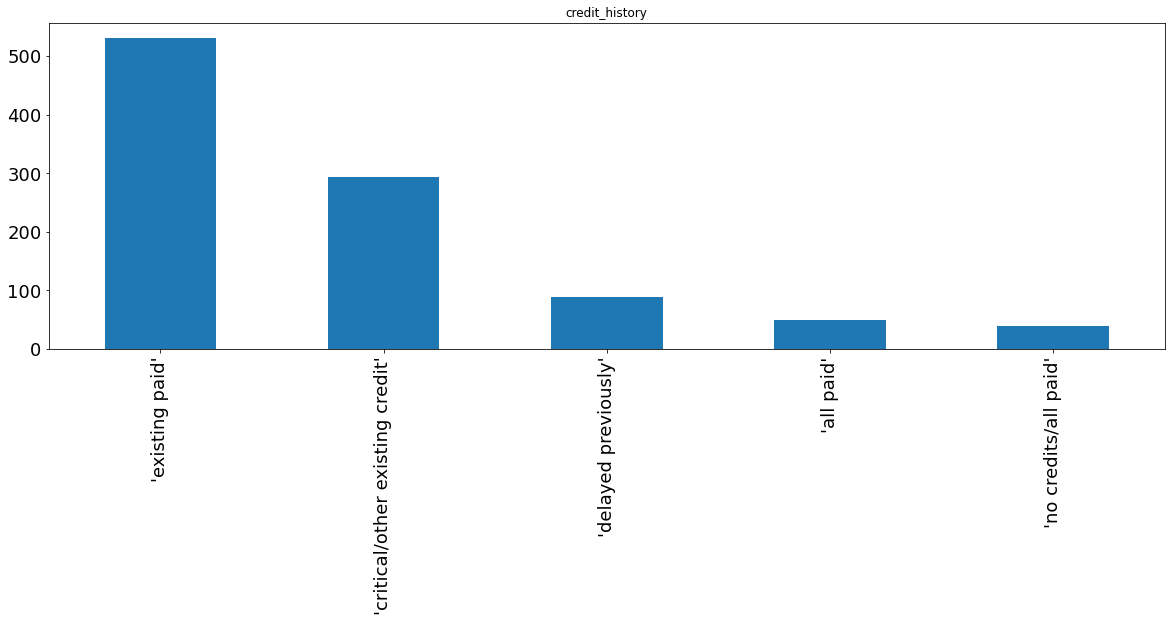

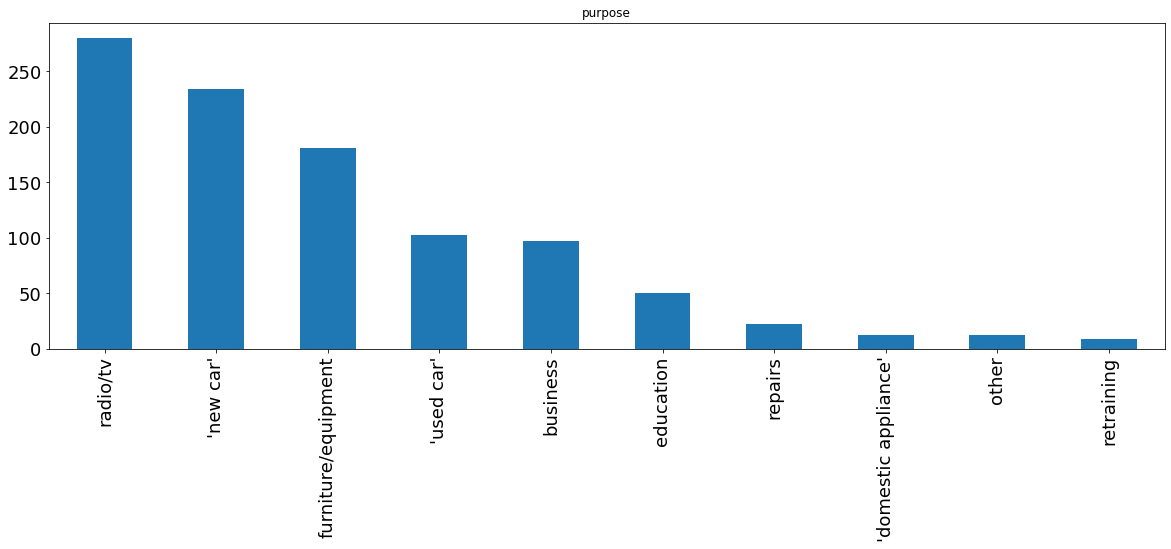

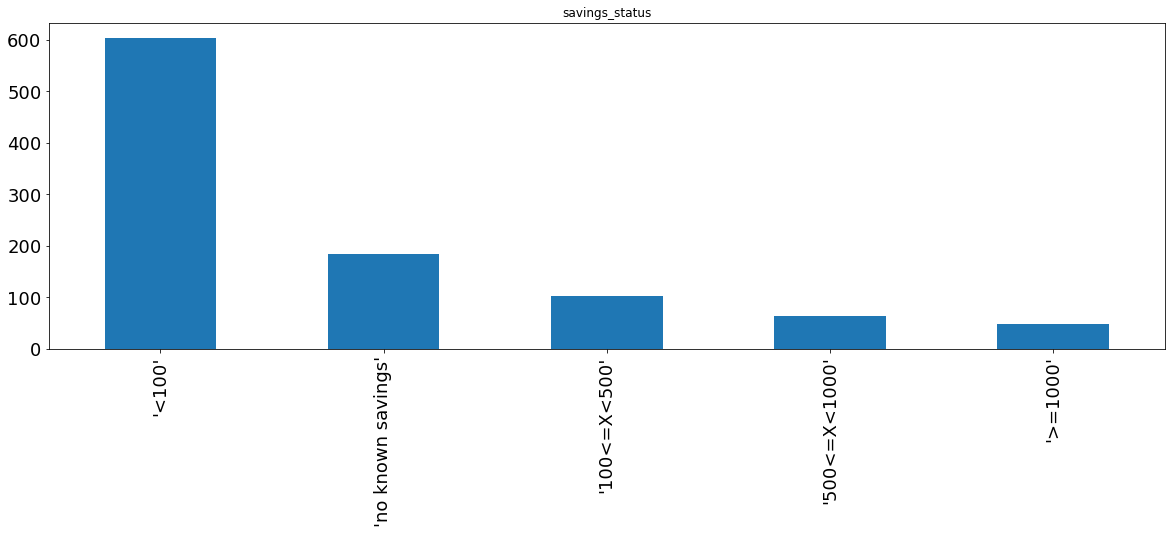

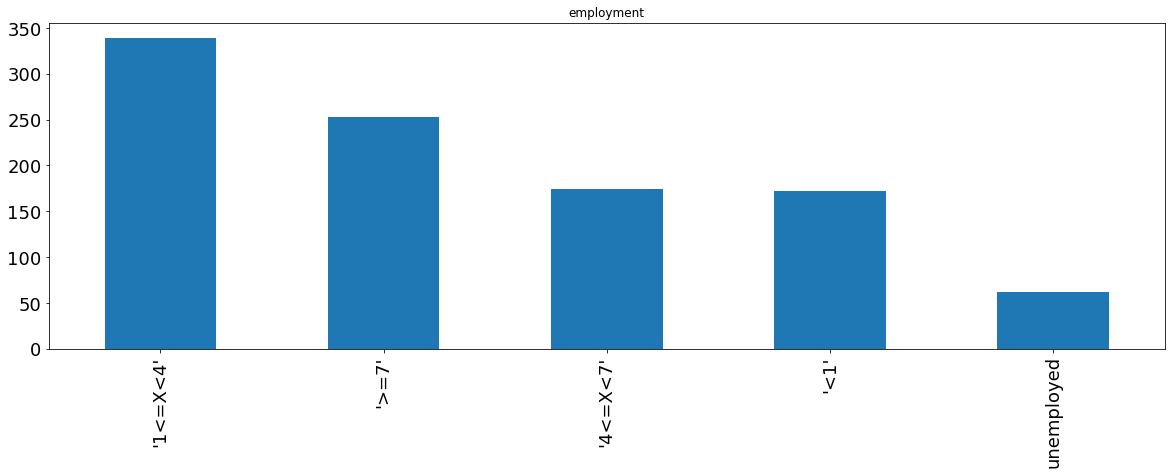

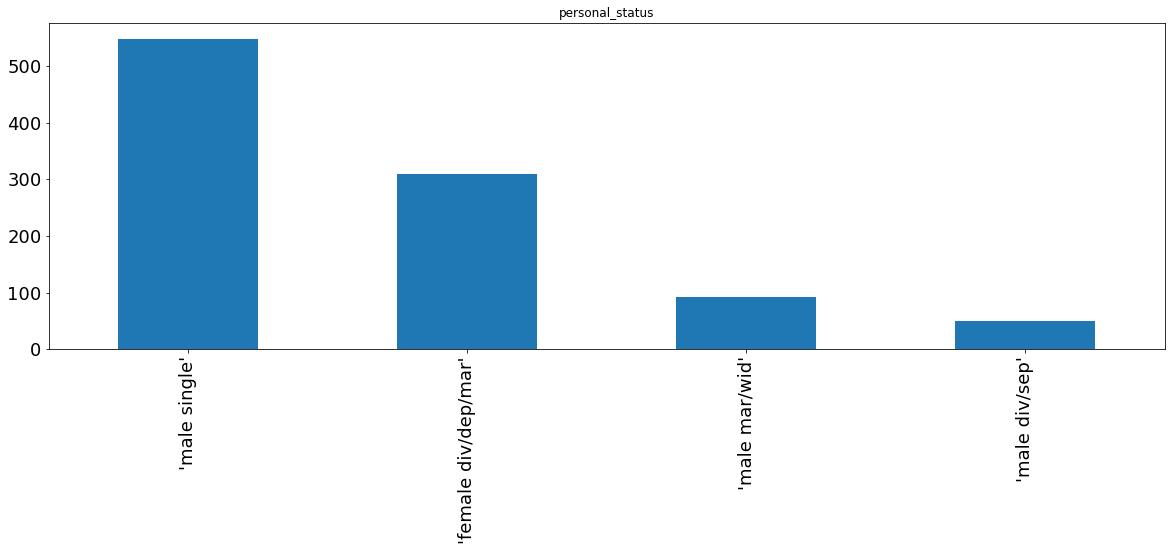

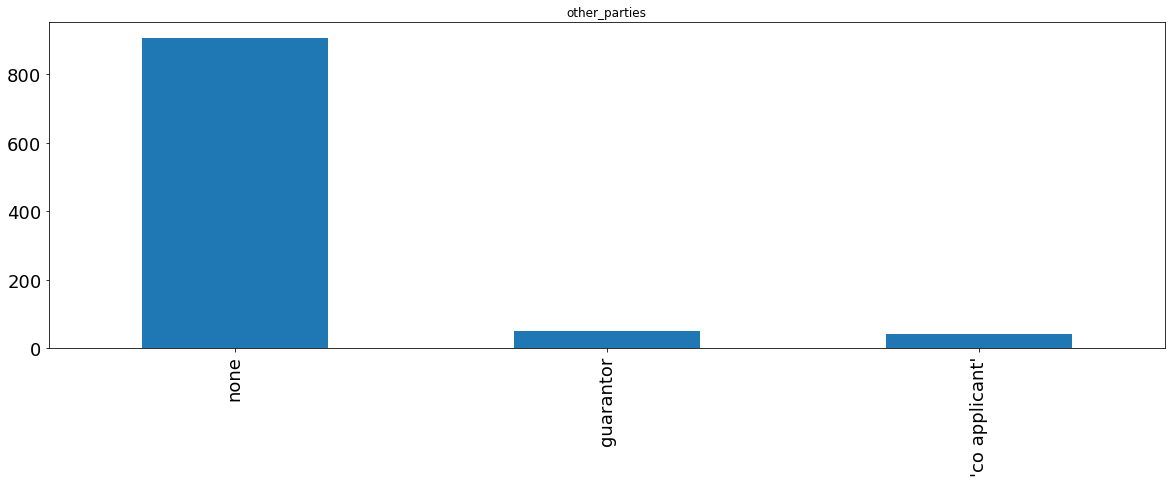

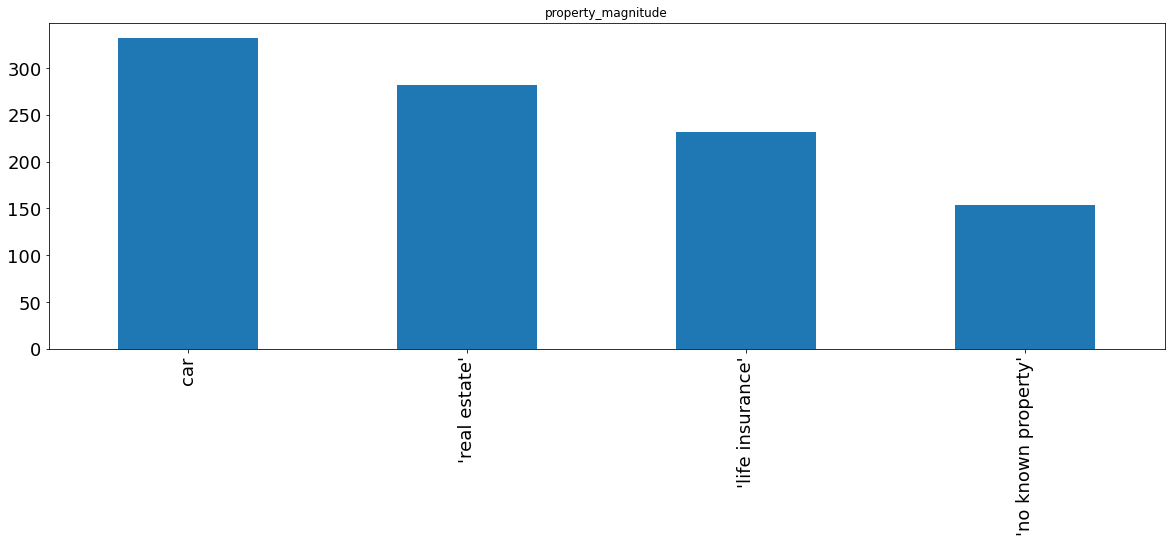

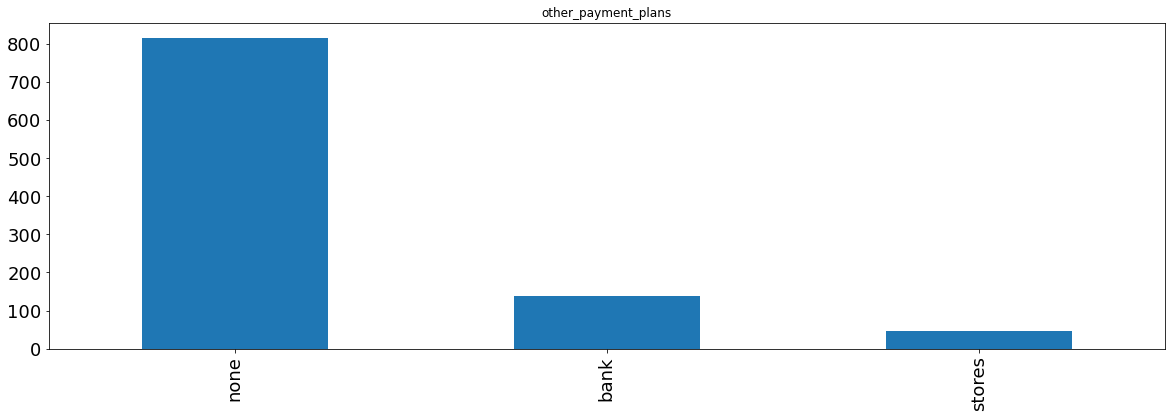

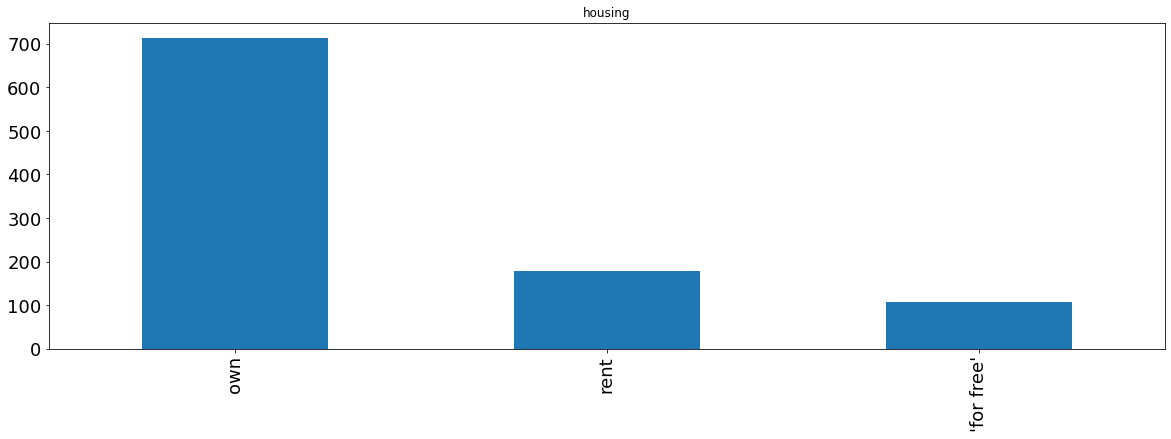

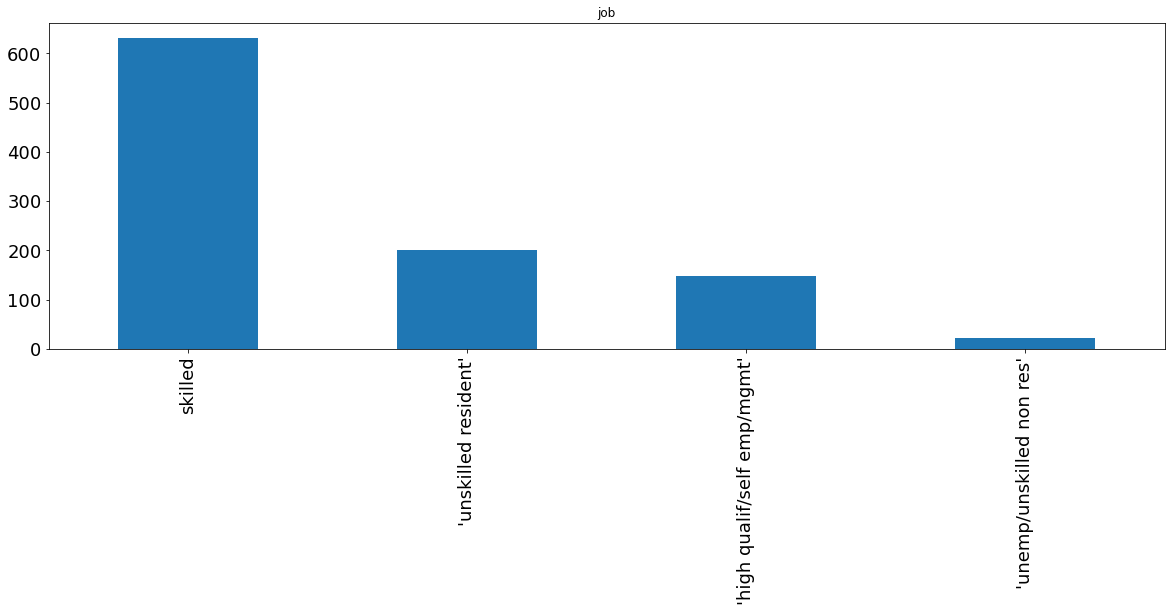

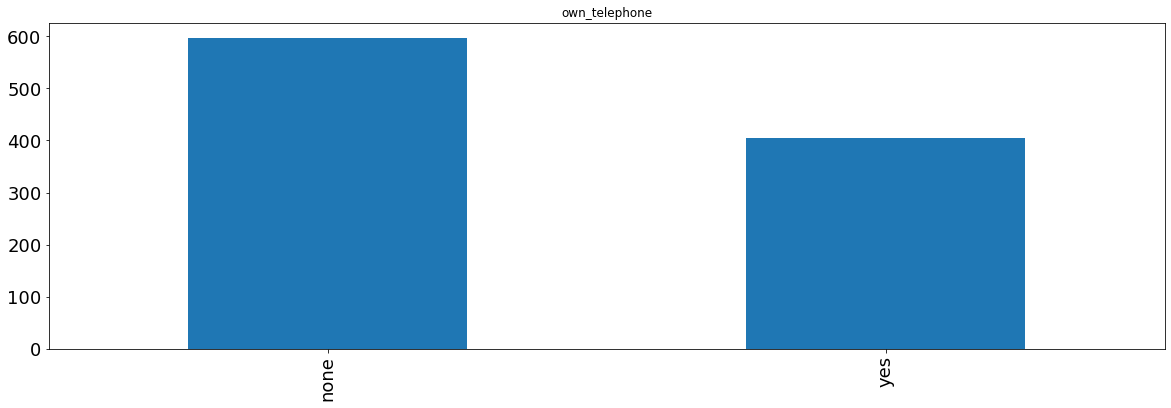

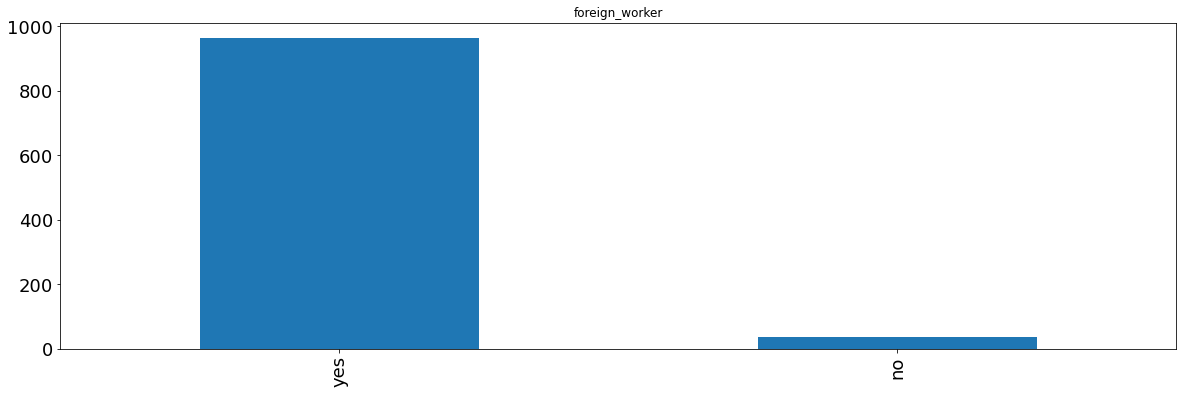

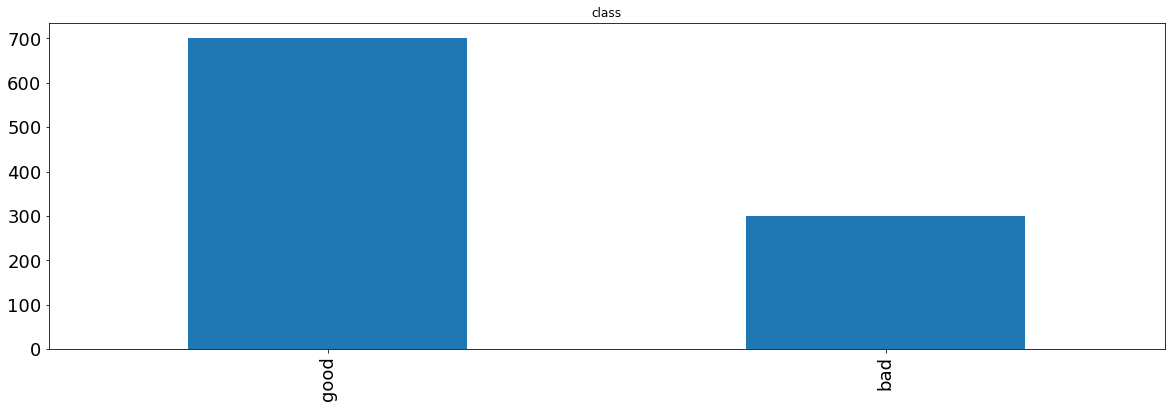

In [9]:
cols_cha = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 
            'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing',
            'job', 'own_telephone', 'foreign_worker', 'class']
for i in cols_cha:
    plt.figure(figsize=(20,6))
    plt.tick_params(axis='x',labelsize=18)
    plt.tick_params(axis='y',labelsize=18)
    plt.title(i)
    df[i].value_counts().plot(kind = 'bar')

Depending on the features, the corresponding processing methods are different. For example, 
- for the 'Personal status' feature, there is no obvious relationship between its values, and the amount of different unique feature values is relatively small, so the onehot method is recommended. 
- As for the feature 'purpose', the amount of unique feature values is relatively large, so using onehot is likely to lead to a sparse data set, therefore, it is recommended to use labelencoding or other methods for processing. 
- For features like 'saving status', there is a clear sequential relationship, although there are only 5 different attribute values, it is still recommended to use labelencoding.

The DataFactory provides methods 'categorical_feature_encoding' to automate the conversion, however, because it is difficult to identify whether a character property has a sequential relationship, the methods provided simply determine which conversion method to use based on the number of property values.

This method take three parameters as input, which is:
- dat_x: pd.DataFrame is the feature of the dataset
- dat_y: pd.Series (optional) is the target of the dataset
- k_term: bool (optional) determines whether to create the kterm feature of each categorical feature or not

In [10]:
datafactory = DataFactory()

In [11]:
dfx, dfy = datafactory.categorical_feature_encoding(dfx, dfy, )

2021-07-20 15:36:50,368 - DataFactory - INFO - + Start to transform the categorical columns
2021-07-20 15:36:50,377 - DataFactory - INFO -     Target given and is object, apply Label encoding to the target
2021-07-20 15:36:50,389 - DataFactory - INFO -     End with Target encoding
2021-07-20 15:36:50,416 - DataFactory - INFO -     K-term function is activated, try to extract the k-term for each object columns
2021-07-20 15:36:50,802 - DataFactory - INFO -     End with k-term feature extraction
2021-07-20 15:36:50,817 - DataFactory - INFO -     Start to do onehot to the following categoric features: ['checking_status', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
2021-07-20 15:36:50,843 - DataFactory - INFO -     End with onehot encoding
2021-07-20 15:36:50,848 - DataFactory - INFO -     Start to do label encoding to the following categoric features:

In [12]:
dfx.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_'<0',checking_status_'>=200',checking_status_'no checking',...,savings_status_kterm,employment_kterm,personal_status_kterm,other_parties_kterm,property_magnitude_kterm,other_payment_plans_kterm,housing_kterm,job_kterm,own_telephone_kterm,foreign_worker_kterm
0,6,1169,4,4,67.0,2,1,1.0,0.0,0.0,...,183,253,548,907,282,814,713,630,404,963
1,48,5951,2,2,22.0,1,1,0.0,0.0,0.0,...,603,339,310,907,282,814,713,630,596,963
2,12,2096,2,3,49.0,1,2,0.0,0.0,1.0,...,603,174,548,907,282,814,713,200,596,963
3,42,7882,2,4,45.0,1,2,1.0,0.0,0.0,...,603,174,548,52,232,814,108,630,596,963
4,24,4870,3,4,53.0,2,2,1.0,0.0,0.0,...,603,339,548,907,154,814,108,630,596,963


In [13]:
dfy.head()

0    1
1    0
2    1
3    1
4    0
dtype: int64

## Datetime
Date data is usually defaulted to object type when the data is read. Direct encoding will mask the time information. DataFactory has implemented a method to extract these information. It take the target columns as input and output a dataframe containing all the information hide in this columns.


In [14]:
df_dt = pd.read_csv(root + 'data/raw_run.csv', sep = ';')

In [15]:
df_dt.head()

,id,artm,start_time,end_time,result,project
0,0,NaN,2017-05-30 09:21:05.000,2017-05-30 09:22:41.607,End of loop,"PCB Assembly: Baseline (4 Resistors, no offset..."
1,1,NaN,2017-05-30 09:22:42.000,2017-05-30 09:24:15.538,End of loop,"PCB Assembly: Baseline (4 Resistors, no offset..."
2,2,NaN,2017-05-30 09:24:15.000,2017-05-30 09:25:49.391,End of loop,"PCB Assembly: Baseline (4 Resistors, no offset..."
3,3,NaN,2017-05-30 09:25:49.000,2017-05-30 09:27:23.323,End of loop,"PCB Assembly: Baseline (4 Resistors, no offset..."
4,4,NaN,2017-05-30 09:27:23.000,2017-05-30 09:28:57.082,End of loop,"PCB Assembly: Baseline (4 Resistors, no offset..."


In [16]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          127 non-null    int64  
 1   artm        0 non-null      float64
 2   start_time  127 non-null    object 
 3   end_time    127 non-null    object 
 4   result      126 non-null    object 
 5   project     127 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.1+ KB


We find that the start_time and end_time are recognized as object here. To extract its inforation, we apply the method below:

In [17]:
datafactory = DataFactory()
datafactory.extract_date_information(df_dt['start_time'])

2021-07-20 15:36:51,173 - DataFactory - INFO - + Start to extract datetime information from: start_time
2021-07-20 15:36:51,321 - DataFactory - INFO - - End with date time information extraction


,start_time_year,start_time_month,start_time_day,start_time_dayofyear,start_time_dayofweek,start_time_hour,start_time_minute,start_time_second,start_time_microsecond
0,2017,5,30,150,1,9,21,5,0
1,2017,5,30,150,1,9,22,42,0
2,2017,5,30,150,1,9,24,15,0
3,2017,5,30,150,1,9,25,49,0
4,2017,5,30,150,1,9,27,23,0
...,...,...,...,...,...,...,...,...,...
122,2017,6,2,153,4,12,15,30,0
123,2017,6,2,153,4,12,15,59,0
124,2017,6,2,153,4,12,35,39,0
125,2017,6,2,153,4,12,38,58,0


In [18]:
dfx.isna().sum()

duration                                           0
credit_amount                                      0
installment_commitment                             0
residence_since                                    0
age                                                1
existing_credits                                   0
num_dependents                                     0
checking_status_'<0'                               0
checking_status_'>=200'                            0
checking_status_'no checking'                      0
credit_history_'critical/other existing credit'    0
credit_history_'delayed previously'                0
credit_history_'existing paid'                     0
credit_history_'no credits/all paid'               0
savings_status_'500<=X<1000'                       0
savings_status_'<100'                              0
savings_status_'>=1000'                            0
savings_status_'no known savings'                  0
employment_'4<=X<7'                           

## NA value
NA value, or missing value is the missing value in the data. When the data with missing value is loaded, the missing value generally appears as NA. Missing values in general can be classified as follows：
- MAR(Missing at random): Random missing means that the probability of missing data is not related to the missing data itself, but only to the partially observed data. That is, the missing data is not completely random and the missing data of that type depends on other complete variables
- MCAR(Missing complete at random): Missing data is completely random
- MNAR(Missing not at random): Missing data is related to the value of the incomplete variable itself, e.g.,Women usually do not want to reveal their age.

There are many reasons for missing values, some of the more classic ones include:
- Information is temporarily unavailable
- Data is not recorded, omitted or lost due to human factors, this is the main reason for missing data
- Data loss due to failure of data acquisition equipment, storage media, transmission media failure
- The cost of obtaining this information is too high
- Some objects have one or more attributes that are not available, e.g., the name of the spouse of an unmarried person

The best way to handle NA value is to analyze the cause of generation and deal with them one by one according to the cause. However, this method is time consuming when the amount of missing values is large, and as an alternative, the following methods are generally used to handle missing values.
- delete feature: If a feature has a relatively high missing rate (80%) and is of low importance, you can simply delete the feature.
- delete record: Not recommended, unless most of the values of the record are na
- filling:
  - filling manually
  - filling dummy: Filling with special value, e.g., 0, 'other'
  - filling statistically: Filling in missing values with statistical values, e.g., mean, max, min, mode 
  - filling interpolation: including random interpolation, multiple differential interpolation, thermal platform interpolation, Lagrangian interpolation, Newton interpolation, etc.
  - filling model: Prediction of missing data using models such as K-nearest neighbor, regression, Bayesian, random forest, and decision tree. 

DataFactory currently implements a method 'clean_dat' with two strategy to fill the na value, i.e., using statistics to fill up and using models to fill up. The first one the least time consuming and the second one is the most accurate.

A noteworthy point is that since most models have requirements for the format of the data, the method converts the data type to float32 and disposes of all inf values, in addition to filling in the na values.

'clean_dat' method takes a dataframe and a string as input and output the dataframe without na:
- dat: pd.DataFrame 
- strategy: string. there are 5 strategies to be selected ['model', 'mean', 'median', 'most_frequent', 'constant']]

First we check how many na values are present in the data.

In [19]:
dfx[dfx['age'].isna()]

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_'<0',checking_status_'>=200',checking_status_'no checking',...,savings_status_kterm,employment_kterm,personal_status_kterm,other_parties_kterm,property_magnitude_kterm,other_payment_plans_kterm,housing_kterm,job_kterm,own_telephone_kterm,foreign_worker_kterm
10,12,1295,3,1,NaN,1,1,0.0,0.0,0.0,...,603,172,310,907,332,814,179,630,596,963


Only in the age feature exists a na-value, next we show the results of different filling methods

In [20]:
datafactory = DataFactory()

In [21]:
dfx = datafactory.clean_dat(dfx, 'model')
dfx.iloc[10,:8]

2021-07-20 15:36:51,478 - DataFactory - INFO - + Start to clean the given dataframe
2021-07-20 15:36:51,486 - DataFactory - INFO -     number of inf and nan are for dataset: (0, 1)
2021-07-20 15:36:51,489 - DataFactory - INFO -     set type to float32 at first && deal with inf.
2021-07-20 15:36:51,496 - DataFactory - INFO -     remove columns with half of nan
2021-07-20 15:36:51,504 - DataFactory - INFO -     remove costant columns
2021-07-20 15:36:51,536 - DataFactory - INFO -    start to fill the columns with nan
2021-07-20 15:36:52,731 - DataFactory - INFO - - Finish with Data cleaning, number of inf and nan now are: (0, 0)


duration                    12.000000
credit_amount             1295.000000
installment_commitment       3.000000
residence_since              1.000000
age                         21.437548
existing_credits             1.000000
num_dependents               1.000000
checking_status_'<0'         0.000000
Name: 10, dtype: float32

In [22]:
tmp = datafactory.clean_dat(dfx, 'mean')
tmp.iloc[10,:8]

2021-07-20 15:36:52,775 - DataFactory - INFO - + Start to clean the given dataframe
2021-07-20 15:36:52,809 - DataFactory - INFO -     number of inf and nan are for dataset: (0, 0)
2021-07-20 15:36:52,815 - DataFactory - INFO -     set type to float32 at first && deal with inf.
2021-07-20 15:36:52,818 - DataFactory - INFO -     remove columns with half of nan
2021-07-20 15:36:52,840 - DataFactory - INFO -     remove costant columns
2021-07-20 15:36:52,953 - DataFactory - INFO - - Finish with Data cleaning, number of inf and nan now are: (0, 0)


duration                    12.000000
credit_amount             1295.000000
installment_commitment       3.000000
residence_since              1.000000
age                         21.437548
existing_credits             1.000000
num_dependents               1.000000
checking_status_'<0'         0.000000
Name: 10, dtype: float32

In [23]:
tmp = datafactory.clean_dat(dfx, 'median')
tmp.iloc[10,:8]

2021-07-20 15:36:52,989 - DataFactory - INFO - + Start to clean the given dataframe
2021-07-20 15:36:53,012 - DataFactory - INFO -     number of inf and nan are for dataset: (0, 0)
2021-07-20 15:36:53,048 - DataFactory - INFO -     set type to float32 at first && deal with inf.
2021-07-20 15:36:53,059 - DataFactory - INFO -     remove columns with half of nan
2021-07-20 15:36:53,066 - DataFactory - INFO -     remove costant columns
2021-07-20 15:36:53,109 - DataFactory - INFO - - Finish with Data cleaning, number of inf and nan now are: (0, 0)


duration                    12.000000
credit_amount             1295.000000
installment_commitment       3.000000
residence_since              1.000000
age                         21.437548
existing_credits             1.000000
num_dependents               1.000000
checking_status_'<0'         0.000000
Name: 10, dtype: float32

In [24]:
tmp = datafactory.clean_dat(dfx, 'most_frequent')
tmp.iloc[10,:8]

2021-07-20 15:36:53,144 - DataFactory - INFO - + Start to clean the given dataframe
2021-07-20 15:36:53,159 - DataFactory - INFO -     number of inf and nan are for dataset: (0, 0)
2021-07-20 15:36:53,161 - DataFactory - INFO -     set type to float32 at first && deal with inf.
2021-07-20 15:36:53,166 - DataFactory - INFO -     remove columns with half of nan
2021-07-20 15:36:53,175 - DataFactory - INFO -     remove costant columns
2021-07-20 15:36:53,251 - DataFactory - INFO - - Finish with Data cleaning, number of inf and nan now are: (0, 0)


duration                    12.000000
credit_amount             1295.000000
installment_commitment       3.000000
residence_since              1.000000
age                         21.437548
existing_credits             1.000000
num_dependents               1.000000
checking_status_'<0'         0.000000
Name: 10, dtype: float32

In [25]:
tmp = datafactory.clean_dat(dfx, 'constant')
tmp.iloc[10,:8]

2021-07-20 15:36:53,296 - DataFactory - INFO - + Start to clean the given dataframe
2021-07-20 15:36:53,310 - DataFactory - INFO -     number of inf and nan are for dataset: (0, 0)
2021-07-20 15:36:53,312 - DataFactory - INFO -     set type to float32 at first && deal with inf.
2021-07-20 15:36:53,321 - DataFactory - INFO -     remove columns with half of nan
2021-07-20 15:36:53,335 - DataFactory - INFO -     remove costant columns
2021-07-20 15:36:53,399 - DataFactory - INFO - - Finish with Data cleaning, number of inf and nan now are: (0, 0)


duration                    12.000000
credit_amount             1295.000000
installment_commitment       3.000000
residence_since              1.000000
age                         21.437548
existing_credits             1.000000
num_dependents               1.000000
checking_status_'<0'         0.000000
Name: 10, dtype: float32

As we know from the above demonstration, the final fill value differs greatly with different fill methods, so you should think carefully about the fill strategy before proceeding with the fill

## Outlier
Outliers are the norm of data distribution, and data that is outside a specific distribution area or range is usually defined as outlier(anomalous or noisy). There are two types of anomalies: 
- pseudo outliers, which are generated due to specific business operation actions and are a normal response to the state of the business, rather than anomalies in the data itself; 
- true outliers, which are not generated by specific business operations, but by anomalies in the distribution of the data itself, i.e., outliers. i.e., outliers. 

From the aspect of detection, outliers can generally be divided into three categories.
- Single-dimensional outliers
- Multi-dimensional outliers
- High-dimensional outliers: Too much dimensionality causes the distance function no longer appliable.

The main methods for detecting outliers are as follows.
- 3 sigma/IQR(Interquartile range:0.75 - 0.25)
- Median absolute deviation: |X-median(X)|/|median(|X-median(X)|)| < threshold
- Distance based 
- Density based
- Clustering based

After finding the outliers, we can handle them with following method:
- Consider whether to delete records based on the number and impact of outliers ->  more information loss
- log scale
- treat as na value
- ignore and select a model that is more robust to outliears, such as decision tree

The DataFactory class implements a method for a single feature outlier dectection and a method for the whole dataset outlier detection, respectively. 

The 'outlier_detection_feature'(former) takes a feature as input, the method analyzes the outlier values in this feature and outputs a judgment whether a value is a outlier or not. 
- value: pd.Series

The 'outlier_detection_dataframe'(latter) takes the whole dataset as input and finds out the outliers on the whole dataset.
- dat: pd.DataFrame 
- strategy: string. there are 5 strategies to be selected ['density', 'high_dimension]]

In [26]:
datafactory = DataFactory()

In [27]:
tmp = datafactory.outlier_detection_feature(dfx['duration'])

2021-07-20 15:36:53,463 - DataFactory - INFO - + Start to dectect outlier for given feature duration with 3 IQR strategy
2021-07-20 15:36:53,476 - DataFactory - INFO - - End with outlier detection, 14 outliers found


In [28]:
tmp = datafactory.outlier_detection_dataframe(dfx, strategy = 'density')

2021-07-20 15:36:53,500 - DataFactory - INFO - + Start to detect outlier for the whole data set with strategy: density
2021-07-20 15:36:53,576 - DataFactory - INFO - - End with outlier detection, 100 outliers found


In [29]:
tmp = datafactory.outlier_detection_dataframe(dfx, strategy = 'high_dimension')

2021-07-20 15:36:53,629 - DataFactory - INFO - + Start to detect outlier for the whole data set with strategy: high_dimension
2021-07-20 15:36:53,813 - DataFactory - INFO - - End with outlier detection, 323 outliers found


## Data balancing 
When dealing with the classification task, the number of instances for each classification varies, which tends to cause the model to favor one class in learning, thus affecting the performance of the model.

A similar problem exists in regression problems, where more input attributes or clusters are used to classify the data, and if the number of instances of each class is very different, the learning of the model will also be affected.
- Upsampling or Downsampling randomly
- Upsampling with other strategies
  - SMOTE: Interpolation among class with few samples to generate additional samples
  - BorderlineSMOTE: Divide all minority samples into three categories first:
      - noise: All k-nearest neighbor samples belong to the majority class
      - danger: Over half k-nearest neighbor samples belong to the majority class
      - safe: More than half of the k-nearest neighbor samples belong to the minority class
    Only sample from the danger categories
  - ADASYN: Different minority class samples yield different number of samples, and then the samples are tried with smote
  - KMeansSMOTE:
      - Clustering: k-means are used to clustering.
      - Filtering: selects the clusters used for upsampling (retains clusters with a high percentage of minority class samples).
      - Then, it assigns the number of synthetic samples, assigning more samples to clusters with a sparse distribution of minority samples
      - Upsampling with SMOTE in each cluster
- Downsampling with other strategies
  - ClusterCentroids: The samples of each class are synthesized using the centroids of the K-Means algorithm, instead of being drawn randomly from the original samples.
  - EditedNearestNeighbours: The samples, that most (kind_sel='mode') or all (kind_sel='all') of their nearest-neighbor samples belong to the same class will be kept in the dataset.
  - RepeatedEditedNearestNeighbours: repeat 'max_iter' times EditedNearestNeighbours
  - ALLKNN: repeat with increasing k value
  - NearMiss: Adding some heuristic rules to select the samples:
      - type1: Select the positive sample with the smallest average distance from the N nearest negative samples;
      - type2: Select the positive sample with the smallest average distance from the N negative samples;
      - type3: For each negative sample, their M nearest neighbors are kept; then, those positive samples with the greatest average distance to the N nearest neighbors are selected.
  - TomekLinks: Sample x and sample y are from different categories and satisfy the following condition, which is called TomekLinks between them: there is no other sample z such that d(x,z) < d(x,y) or d(y,z) < d(x,y) holds
  - CondensedNearestNeighbour
  - OneSidedSelection: CondensedNearestNeighbour + TomekLinks
- Combine
  - Upsampling tends to generate overlap, combining upsampling and downsampling can effectively solve this problem

The DataFactory wraps the methods mentioned above and provides the following interface:
- sampling_up(dfx:pd.DataFrame, dfy:pd.Series, strategy:str): strategy should be one of ['smote', 'random', 'borderline', 'adasyn', 'kmeanssmote']
- sampling_down(dfx:pd.DataFrame, dfy:pd.Series, strategy:str): strategy should be one of ['cluster', 'random', 'nearmiss1', 'nearmiss2', 'nearmiss3', 'tomek', 'enn', 'repeatenn', 'allknn', 'condensednn']
- sampling_combine(dfx:pd.DataFrame, dfy:pd.Series, strategy:str): strategy should be one of ['smoteenn', 'smotetomek']

In [30]:
data_factory = DataFactory()

<AxesSubplot:>

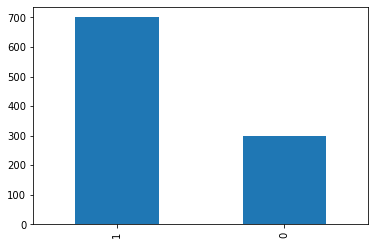

In [31]:
dfy.value_counts().plot(kind = 'bar')

### Upsampling

In [32]:
res_x, res_y = data_factory.sampling_up(dfx, dfy, 'smote')
res_y.value_counts()

2021-07-20 15:36:54,167 - DataFactory - INFO - + Start to apply upsampling strategy: smote
2021-07-20 15:36:54,204 - DataFactory - INFO - - End with upsampling


1    700
0    700
dtype: int64

<AxesSubplot:>

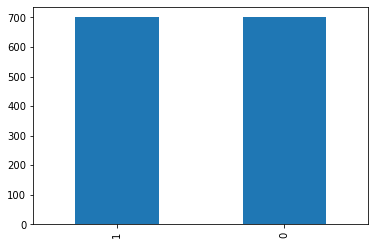

In [33]:
res_y.value_counts().plot(kind = 'bar')

### Downsampling

2021-07-20 15:36:54,572 - DataFactory - INFO - + Start to apply downsampling strategy: enn
2021-07-20 15:36:54,911 - DataFactory - INFO - - End with downsampling


<AxesSubplot:>

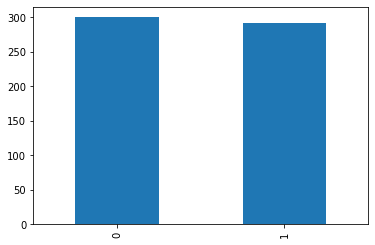

In [34]:
res_x, res_y = data_factory.sampling_down(dfx, dfy, 'enn')
res_y.value_counts()
res_y.value_counts().plot(kind = 'bar')

### Combined sampling

2021-07-20 15:36:55,229 - DataFactory - INFO - + Start to apply combine sampling strategy: smotetomek
2021-07-20 15:36:55,383 - DataFactory - INFO - - End with combine sampling


<AxesSubplot:>

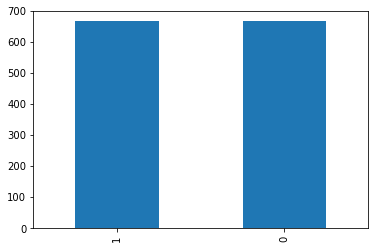

In [35]:
res_x, res_y = data_factory.sampling_combine(dfx, dfy, 'smotetomek')
res_y.value_counts()
res_y.value_counts().plot(kind = 'bar')